In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib.colors import ListedColormap

2025-09-08 11:25:17.928055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0.5, 1.0, 'Ground Truth')

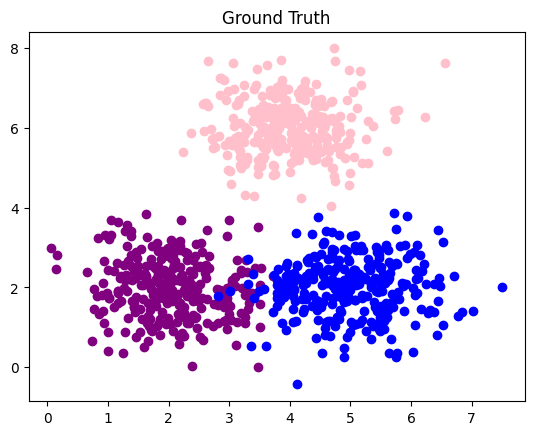

In [3]:
# parameters for Gaussian clusters
cov = [[.5, 0], [0, .5]]  # covariance matrix
mean1 = [2, 2] 
mean2 = [5, 2]
mean3 = [4, 6]
size = 300      # points/cluster

# Generate the data for each cluster
cluster1 = np.random.multivariate_normal(mean1, cov, size)
cluster2 = np.random.multivariate_normal(mean2, cov, size)
cluster3 = np.random.multivariate_normal(mean3, cov, size)
plt.figure()
plt.scatter(cluster1[:,0], cluster1[:,1], color="purple", label="cluster 1")
plt.scatter(cluster2[:,0], cluster2[:,1], color="blue", label="cluster 2")
plt.scatter(cluster3[:,0], cluster3[:,1], color="pink", label="cluster 3")
plt.title("Ground Truth")

In [4]:
#create the model
model = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dense(3, activation='softmax')  # Output layer for 3-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
#train the model
zeros = np.zeros((cluster1.shape[0], 1))
cluster1wanswer = np.hstack((cluster1, zeros))

ones = np.full((cluster2.shape[0], 1), 1)
cluster2wanswer = np.hstack((cluster2, ones))

twos = np.full((cluster3.shape[0], 1), 2)
cluster3wanswer = np.hstack((cluster3, twos))
everything = np.concatenate((cluster1wanswer, cluster2wanswer, cluster3wanswer))
np.random.shuffle(everything)
X = everything[:, 0:2]
y = everything[:, 2]

model.fit(X, y, epochs=20, batch_size=10)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.2261
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.2310
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9442 - loss: 0.2231
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9667 - loss: 0.1870
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.1683
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.1717
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.1667
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.1599
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.1421
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.1445
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9851 - loss: 0.1233
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9691 - lo

In [15]:
#print out the weights and accuracy
weights1, biases1 = model.layers[0].get_weights()
print("Weights for first layer:\n", weights1)
print("Biases for first layer:\n", biases1)

weights2, biases2 = model.layers[1].get_weights()
print("Weights for second layer:\n", weights2)
print("Biases for second layer:\n", biases2)

#get accuracy of model
loss, accuracy = model.evaluate(X, y, verbose=0)
print("Accuracy:", accuracy)

Weights for first layer:
 [[ 0.60267603 -0.4965804  -0.36546364  0.4491951   0.00321392 -0.00987425
   0.6992193   0.90987563]
 [ 0.13999532 -0.30593374  0.74264586  0.10067379 -0.75446856  1.1016321
  -0.37256396  0.05211463]]
Biases for first layer:
 [ 1.0167632   0.          1.1804392   0.05442718 -0.04875073 -1.2181208
 -0.59142536 -1.1955144 ]
Weights for second layer:
 [[ 0.7562955   0.5952156  -0.59280497]
 [ 0.69264084 -0.26909247 -0.26505154]
 [ 0.5929235  -1.169107   -0.24528915]
 [ 0.07259589 -0.4947499   0.4394744 ]
 [-0.34458855  0.5580326  -0.58062005]
 [-1.0609696  -0.21880795  1.2323426 ]
 [-0.8669905   0.95625573 -1.1531487 ]
 [-0.96566     0.5497536   0.08050026]]
Biases for second layer:
 [ 1.1896129 -0.6496516 -0.9876512]
Accuracy: 0.9800000190734863


1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step


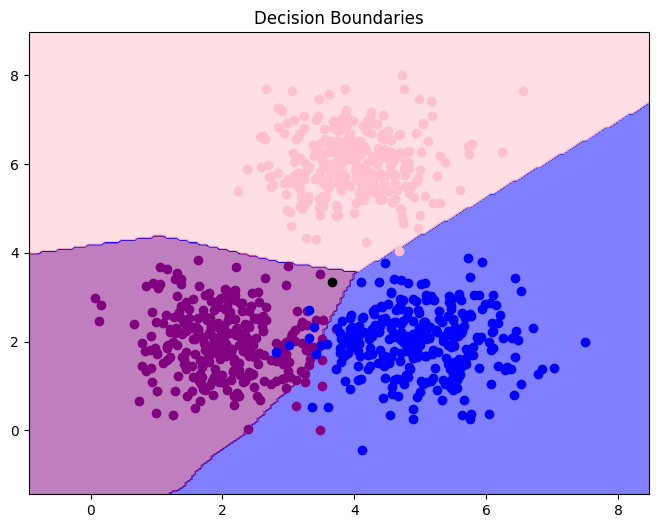

In [ ]:
#graphing prediction boundaries and center point


# Step 1: Create a meshgrid over the input space
h = 0.05  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Step 2: Predict the class for each point in the grid
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

# Step 3: Plot the decision boundary
custom_cmap = ListedColormap(["purple", "blue", "pink"])
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.5)

# Overlay the original training data
plt.scatter(cluster1[:,0], cluster1[:,1], color="purple", label="cluster 1")
plt.scatter(cluster2[:,0], cluster2[:,1], color="blue", label="cluster 2")
plt.scatter(cluster3[:,0], cluster3[:,1], color="pink", label="cluster 3")
plt.title("Decision Boundaries")

centerx, centery = (mean1[0]+mean2[0]+mean3[0])/3, (mean1[1]+mean2[1]+mean3[1])/3
plt.scatter(centerx, centery, color="black", label="center of boundaries")
plt.show()



Text(0.5, 1.0, 'Rotated')

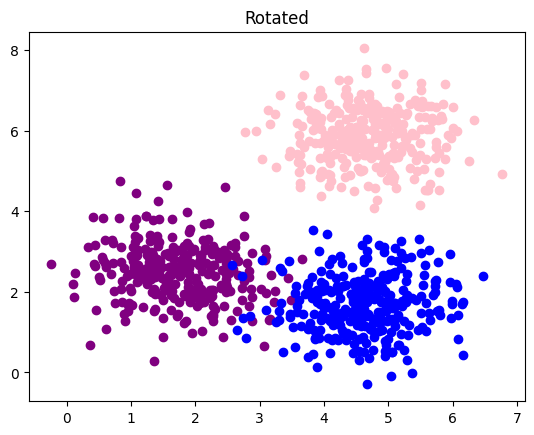

In [19]:
#create new model with rotation
import math
degrees = 15
def rotate(ogx, ogy, cx, cy, degrees):
    #degrees counter clockwise
    # Convert angle to radians
    angle = math.radians(degrees)
    # Translate point back to origin
    dx, dy = ogx - cx, ogy - cy
    # Apply clockwise rotation
    qx = math.cos(angle) * dx + math.sin(angle) * dy
    qy = -math.sin(angle) * dx + math.cos(angle) * dy
    # Translate point back
    return (qx + cx, qy + cy)
rotmean1 = rotate(mean1[0], mean1[1], centerx, centery, degrees)
rotmean2 = rotate(mean2[0], mean2[1], centerx, centery, degrees)
rotmean3 = rotate(mean3[0], mean3[1], centerx, centery, degrees)

# parameters for Gaussian clusters
cov = [[.5, 0], [0, .5]]  # covariance matrix
size = 300      # points/cluster

# Generate the data for each cluster
cluster1 = np.random.multivariate_normal(rotmean1, cov, size)
cluster2 = np.random.multivariate_normal(rotmean2, cov, size)
cluster3 = np.random.multivariate_normal(rotmean3, cov, size)
plt.figure()
plt.scatter(cluster1[:,0], cluster1[:,1], color="purple", label="cluster 1")
plt.scatter(cluster2[:,0], cluster2[:,1], color="blue", label="cluster 2")
plt.scatter(cluster3[:,0], cluster3[:,1], color="pink", label="cluster 3")
plt.title("Rotated")


In [ ]:
#TODO: try adjusting weights now with forward and backpropogation one by one

#weights to use